In [2]:
import pandas as pd
from scipy.io import mmread
import scipy.sparse
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [3]:
feature_matrix = mmread("../Data/FeatureMatrix.mtx")
genes = pd.read_csv("../Data/Genes.csv")
positions = pd.read_csv('../Data/SpotPositions.csv')
ScatterPies = pd.read_csv('../Data/SpotClusterMembership.csv')

In [4]:
expression_data = pd.DataFrame(feature_matrix, index=positions['barcode'], columns=genes['gene'])
expression_data

gene,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
barcode,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTTCCCGGATT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0


In [5]:
merged_df = pd.merge(positions, ScatterPies, on='barcode')
merged_df

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.130452,0.000000,0.277719,0.000000,0.334386,0.000000,0.000000,0.080847
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,0.193410,0.144084,0.000000
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.250267,0.000000,0.163155,0.256573
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.463777,0.000000,0.237417,0.131194,0.080076
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.216818,0.000000,0.126936,0.099019,0.067587,0.292446,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.109485,0.372448,0.095749,0.344632,0.000000,0.000000,0.000000
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.083465,0.134945,0.000000,0.208435,0.121374,0.000000,0.124215,0.272560
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.545618,0.000000,0.161659,0.148889,0.075935
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.171150,0.191596,0.000000,0.175395,0.240660


In [5]:
merged_df.to_csv('../Frontend/src/data/piechart.csv', index=False)

In [10]:
# find rows where all values in columns X1-X9 are not 0 
filter_df = merged_df[(merged_df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']] != 0).all(axis=1)]
filter_df

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
453,AGATAACTTCAGGGCC-1,6359.0,7370.0,71.192911,0.149578,0.090838,0.066249,0.054326,0.236025,0.091684,0.059067,0.159360,0.092872
2033,GCCTATAGTGTCAGGG-1,11508.0,6803.0,71.192911,0.096661,0.109013,0.063389,0.107851,0.308025,0.129497,0.068907,0.052388,0.064270
2213,GGCACTCCACTGGGCA-1,6578.0,7751.0,71.192911,0.092856,0.097069,0.055163,0.063332,0.304833,0.075148,0.060642,0.156100,0.094857
2370,GTAATAAAGGGCTCCC-1,12822.0,7185.0,71.192911,0.053117,0.153904,0.051398,0.070595,0.328283,0.076743,0.112094,0.078818,0.075047
2468,GTGAAGCCGTATAGTC-1,13262.0,5280.0,71.192911,0.373724,0.122477,0.078600,0.061449,0.118235,0.059094,0.053357,0.081445,0.051620
2554,GTTCGTCTGGGTCCCT-1,14576.0,5281.0,71.192911,0.130957,0.054208,0.101681,0.067767,0.247992,0.176499,0.091569,0.075410,0.053918
2835,TCACAGGTTATTGGGC-1,6797.0,7370.0,71.192911,0.084002,0.155032,0.066182,0.076723,0.212137,0.075990,0.072791,0.159356,0.097787
2902,TCCGAAGTAGTCACCA-1,13591.0,3946.0,71.192911,0.105235,0.050853,0.070518,0.079200,0.217468,0.238641,0.086357,0.099968,0.051759
3108,TGATCTCCGGCGCCAG-1,7017.0,6608.0,71.192911,0.108314,0.130011,0.139281,0.057951,0.096534,0.078358,0.123449,0.141784,0.124318


In [6]:
position_merged_df = pd.merge(positions, expression_data, on='barcode')
position_merged_df

,barcode,x,y,radius,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
expression_data['Gm1992'].value_counts()

Gm1992
0.0    3495
1.0       4
Name: count, dtype: int64

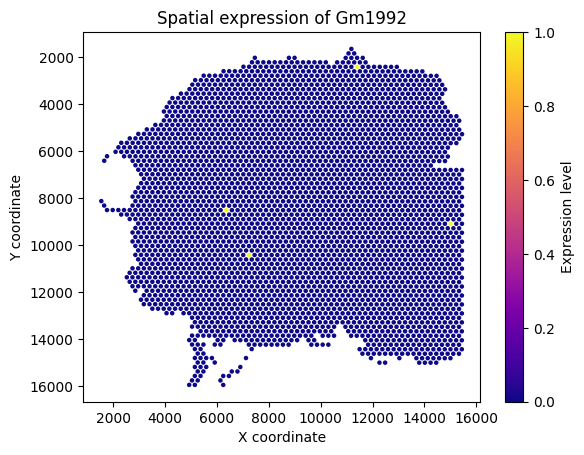

In [37]:
# Select a gene to visualize
gene_of_interest = 'Gm1992'

# Create a scatter plot of the expression of the gene of interest
plt.scatter(positions['x'], positions['y'], c=expression_data[gene_of_interest], cmap='plasma', s=5)
plt.colorbar(label='Expression level')
plt.title(f'Spatial expression of {gene_of_interest}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.gca().invert_yaxis()
plt.show()

In [12]:
spotDiameter = 142.38582253945773
scalef = 0.03479471
radius = (spotDiameter * scalef / 2)

# Define the equation to solve
def equation(x, a, r):
    return x - (90 * a + (90 / (4 * np.pi * r**2)) * np.sin(2 * x))

# Function to solve for x
def solve_for_x(a, r=radius):
    if a == 0:
        return 0
    x0 = 5  # Initial guess
    x_solution = fsolve(equation, x0, args=(a, r))
    return x_solution[0]

# Calculate the new DataFrame with x values
def calculate_x_values(df, r=radius):
    result_df = df.copy()
    for index, row in df.iterrows():
        cumulative_sum = 0
        for i in range(1, 10):
            a_value = row[f'X{i}']
            cumulative_sum += a_value
            if a_value == 0:
                result_df.loc[index, f'X{i}_angle'] = 0
            else:
                result_df.loc[index, f'X{i}_angle'] = solve_for_x(cumulative_sum, r)
    return result_df

# Apply the function to the DataFrame
result_df = calculate_x_values(merged_df)

result_df


/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten itera

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,...,X9,X1_angle,X2_angle,X3_angle,X4_angle,X5_angle,X6_angle,X7_angle,X8_angle,X9_angle
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.130452,0.000000,0.277719,0.000000,0.334386,...,0.080847,16.820188,26.993931,0.000000,53.978778,0.000000,83.091811,0.000000,0.000000,89.676025
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.738874,0.000000,76.988042,89.676025,0.000000
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.250267,...,0.256573,0.000000,0.000000,29.801718,0.000000,0.000000,51.953472,0.000000,67.350181,89.676025
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.463777,0.000000,...,0.080076,0.000000,5.718967,0.000000,0.000000,48.982613,0.000000,72.820907,83.113290,89.676025
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.216818,0.000000,0.126936,0.099019,0.067587,...,0.000000,19.413138,36.489456,0.000000,48.691869,57.960914,62.267598,89.676025,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.109485,0.372448,0.095749,0.344632,...,0.000000,5.718933,0.000000,15.143786,50.189846,58.387339,89.676025,0.000000,0.000000,0.000000
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.083465,0.134945,0.000000,0.208435,0.121374,...,0.272560,4.784005,12.644824,25.696771,0.000000,44.546424,52.843143,0.000000,64.740166,89.676025
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.545618,0.000000,...,0.075935,0.000000,5.176513,0.000000,0.000000,55.049615,0.000000,70.399101,83.226303,89.676025
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.171150,0.191596,...,0.240660,0.000000,0.000000,18.285625,0.000000,35.875927,53.970181,0.000000,67.789916,89.676025


In [13]:
result_df.to_csv('../Frontend/src/data/kosaraChart.csv', index=False)